In [1]:
#%% Packages
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

# %% Data Import
data = sns.load_dataset("flights")
print(f'Number of Entries: {len(data)}')
data.head(20)


Number of Entries: 144


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
5,1949,Jun,135
6,1949,Jul,148
7,1949,Aug,148
8,1949,Sep,136
9,1949,Oct,119


<Axes: xlabel='year'>

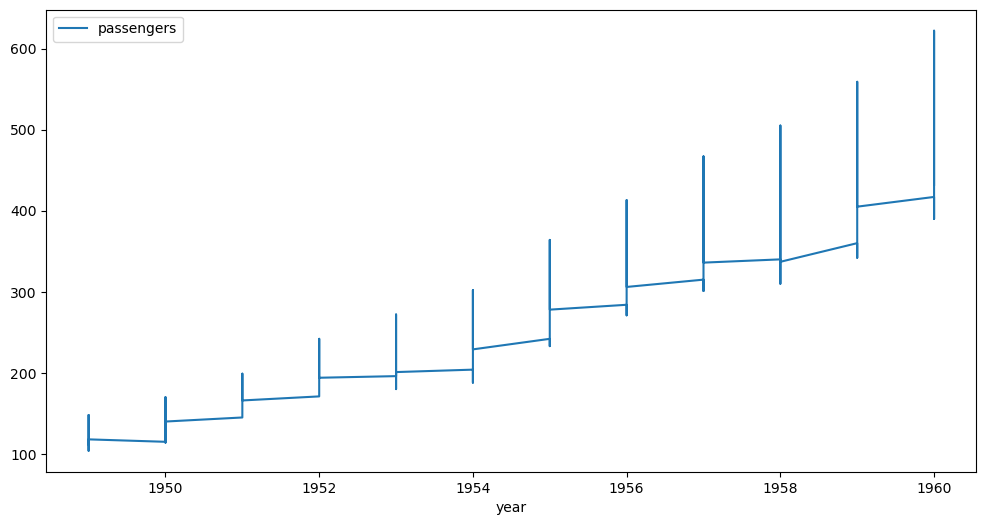

In [2]:
data.plot(x='year', y='passengers', figsize=(12, 6))

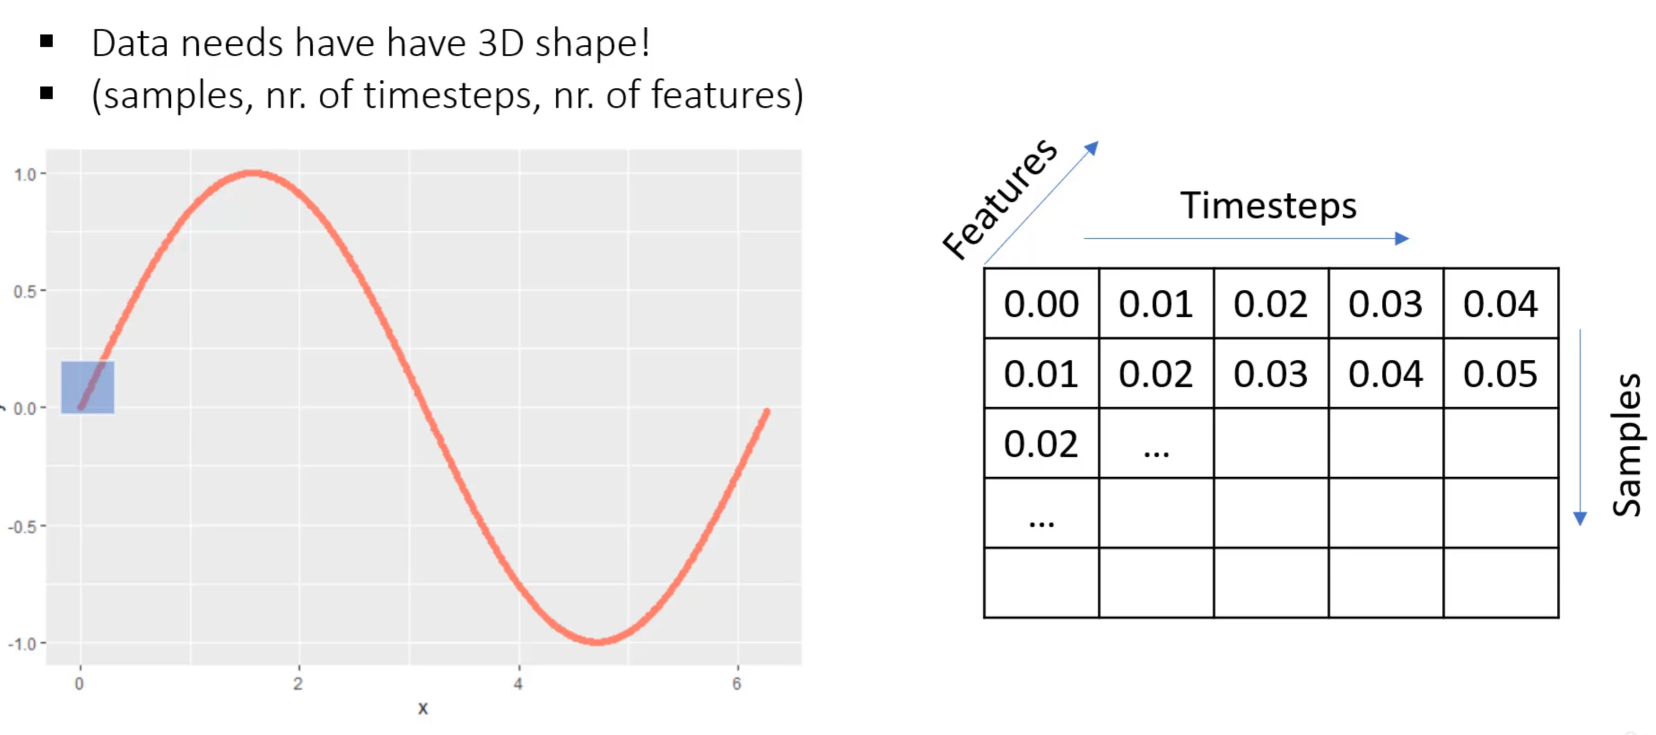{width=30px height=30px}



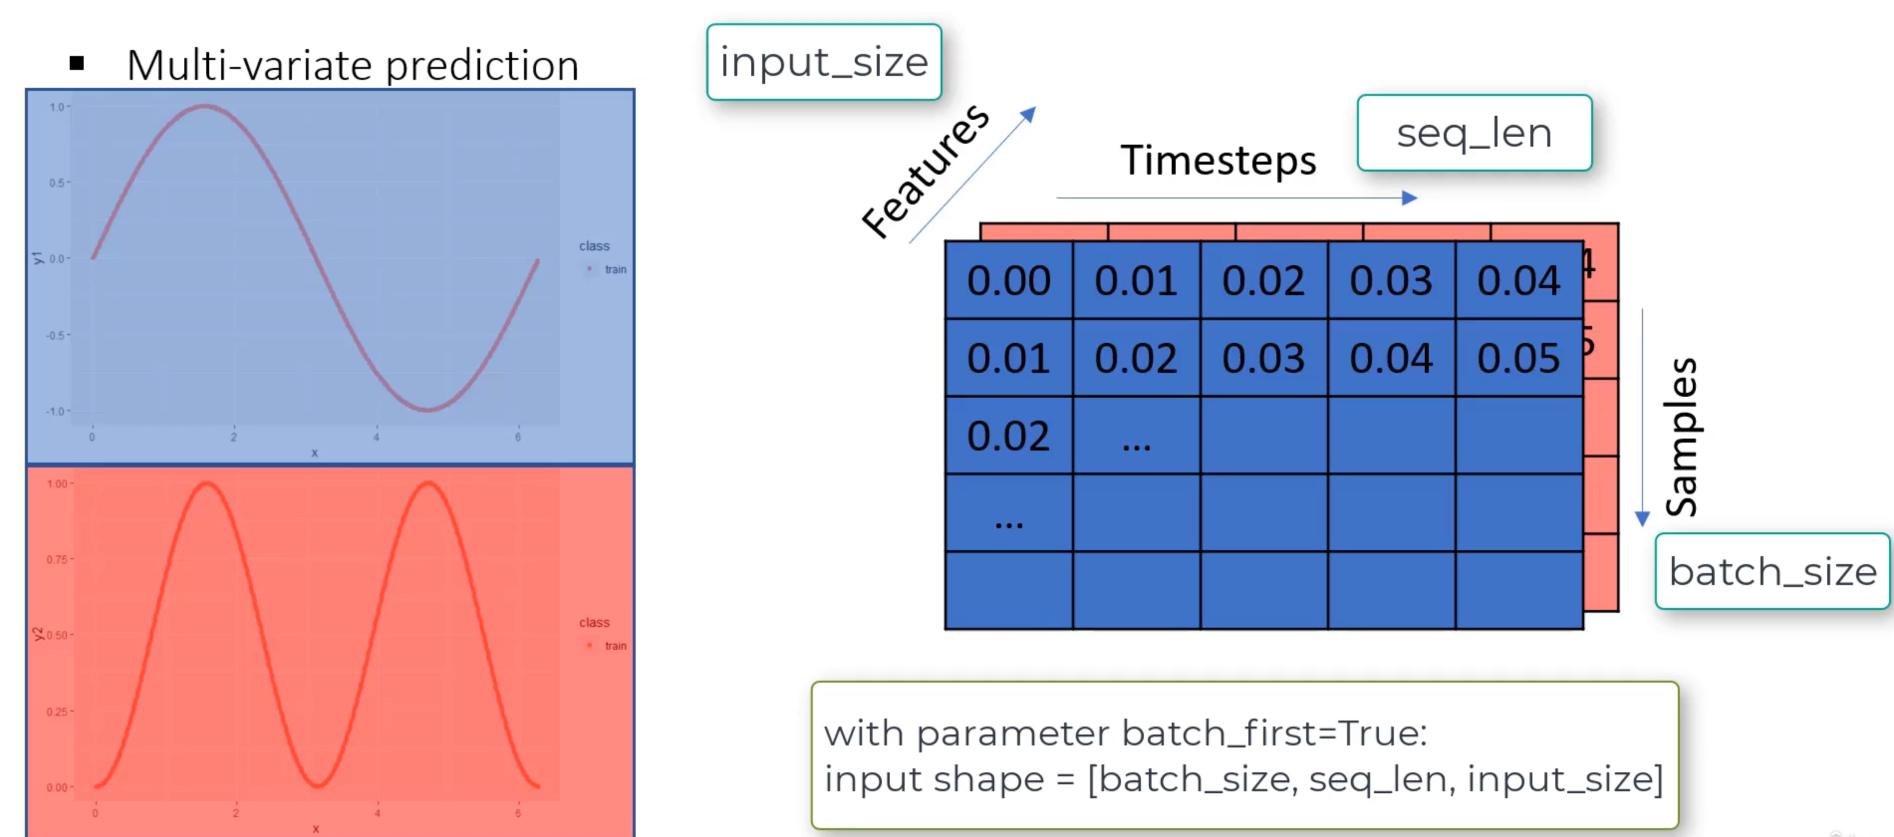{width=30px height=30px}

In [5]:
# %%
# Convert passenter data to float32 for PyTorch
num_points = len(data)
Xy = data.passengers.values.astype(np.float32)

#%% scale the data
scaler = MinMaxScaler()

Xy_scaled = scaler.fit_transform(Xy.reshape(-1, 1))


# %% Data Restructuring
X_restruct = [] 
y_restruct = [] 

for i in range(num_points-10):
     list1 = []
     for j in range(i,i+10):
         list1.append(Xy_scaled[j])
     X_restruct.append(list1)
     y_restruct.append(Xy_scaled[j+1])
X_restruct = np.array(X_restruct)
y_restruct = np.array(y_restruct)

#%% train/test split
last_n_months = 12
clip_point = len(X_restruct) - last_n_months
X_train = X_restruct[:clip_point]
X_test = X_restruct[clip_point:]
y_train = y_restruct[:clip_point]
y_test = y_restruct[clip_point:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



X_train shape: (122, 10, 1)
y_train shape: (122, 1)
X_test shape: (12, 10, 1)
y_test shape: (12, 1)


In [6]:
# %%
class FlightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataloader
train_loader = DataLoader(FlightDataset(X_train, y_train), batch_size=2)
test_loader = DataLoader(FlightDataset(X_test, y_test), batch_size=len(y_test))



In [7]:
for x, y in train_loader:
    print(f"X shape: {x.shape}")
    print(f"y shape: {y.shape}")
    break

X shape: torch.Size([2, 10, 1])
y shape: torch.Size([2, 1])


In [19]:
# %%
class FlightModel(nn.Module):
    def __init__(self, input_size=1, output_size=1):
        super(FlightModel, self).__init__()
        self.hidden_size = 50
        self.lstm = nn.LSTM(input_size, hidden_size=self.hidden_size, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=self.hidden_size, out_features=output_size)
    
    def forward(self, x):
        output, _ = self.lstm(x)    
        output = output[:, -1, :]
        output = self.fc1(torch.relu(output))
        return output



In [20]:
# %% Model, Loss and Optimizer
model = FlightModel()

loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
NUM_EPOCHS = 200

#%% Train
for epoch in range(NUM_EPOCHS):
    for j, data in enumerate(train_loader):
        X, y = data
       
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fun(y_pred, y)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.data}")


# %% Create Predictions
test_set = FlightDataset(X_test, y_test)
X_test_torch, y_test_torch = next(iter(test_loader))
with torch.no_grad():
    y_pred = model(X_test_torch)
y_act = y_test_torch.numpy().squeeze()
x_act = range(y_act.shape[0])


# %%

Epoch: 0, Loss: 0.0069944304414093494
Epoch: 10, Loss: 0.012791440822184086
Epoch: 20, Loss: 0.005380484741181135
Epoch: 30, Loss: 0.004572281613945961
Epoch: 40, Loss: 0.0009070225059986115
Epoch: 50, Loss: 3.25736436934676e-05
Epoch: 60, Loss: 0.0009515692945569754
Epoch: 70, Loss: 0.0009499270236119628
Epoch: 80, Loss: 0.0012107747606933117
Epoch: 90, Loss: 0.0006373789510689676
Epoch: 100, Loss: 0.00047230214113369584
Epoch: 110, Loss: 0.0002051687624771148
Epoch: 120, Loss: 0.00020831546862609684
Epoch: 130, Loss: 5.179185973247513e-05
Epoch: 140, Loss: 9.721704373077955e-06
Epoch: 150, Loss: 4.6348861360456795e-05
Epoch: 160, Loss: 0.0002552598889451474
Epoch: 170, Loss: 7.013702997937799e-05
Epoch: 180, Loss: 1.007075070447172e-06
Epoch: 190, Loss: 0.00010992420720867813


<Axes: ylabel='None'>

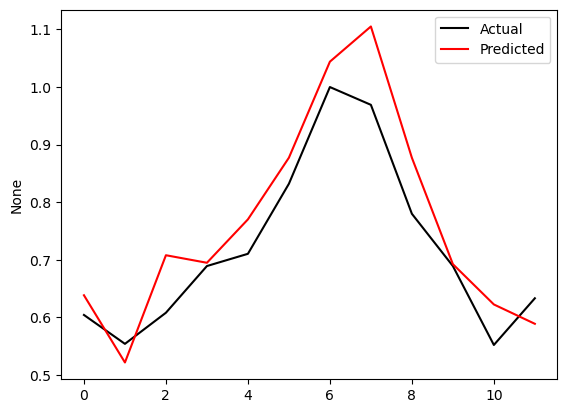

In [21]:
sns.lineplot(x=x_act, y=y_act, label = 'Actual',color='black')
sns.lineplot(x=x_act, y=y_pred.squeeze(), label = 'Predicted',color='red')
